In [1]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten, Lambda, Layer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras import backend as K
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
keras.__version__

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.6'

In [2]:
train_imgs = []
for filename in os.listdir('train/'):
    img = load_img('train/'+filename, target_size=(300, 300))
    arr = img_to_array(img)
    train_imgs.append(arr)

# to numpy array as floats
train_rgb = np.array(train_imgs, dtype=float)

# range from 0 to 1.0
train_rgb = 1.0/255*train_rgb

train = rgb2lab(train_rgb)

train = train / 128

In [3]:

train_x = train[:,:,:,:1]
train_y = train[:,:,:,1:]
print(train_x[1,:,:,0])
print(train_x.shape)
print(train_y.shape)
train_x[1,:,:,0].shape

[[0.76736164 0.76465528 0.76465528 ... 0.69511342 0.69511342 0.68395748]
 [0.76079412 0.78047947 0.78047947 ... 0.70207177 0.70207177 0.6942164 ]
 [0.76079412 0.78047947 0.78047947 ... 0.70207177 0.70207177 0.6942164 ]
 ...
 [0.39063865 0.33426233 0.33426233 ... 0.32938855 0.32938855 0.29091986]
 [0.39063865 0.33426233 0.33426233 ... 0.32938855 0.32938855 0.29091986]
 [0.40606954 0.35970662 0.35970662 ... 0.37999122 0.37999122 0.30821834]]
(72, 300, 300, 1)
(72, 300, 300, 2)


(300, 300)

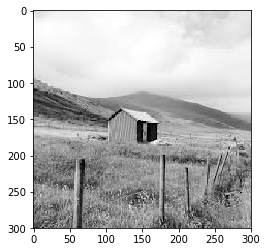

In [4]:
# Show an image
img = train_x[0,:,:,0]

plt.imshow(img, cmap='gray')
plt.show()

In [5]:
# Define both loss functions

# y_true: True labels. TensorFlow/Theano tensor.
# y_pred: Predictions. TensorFlow/Theano tensor of the same shape as y_true.
def colorization_loss(y_true, y_pred):
    return

In [6]:
# Take NNEncode from colorful colorization paper

import sklearn.neighbors as nn

class NNEncode():
    ''' Encode points using NN search and Gaussian kernel '''
    def __init__(self,NN,sigma,km_filepath='',cc=-1):
        if(check_value(cc,-1)):
            self.cc = np.load(km_filepath)
        else:
            self.cc = cc
        self.K = self.cc.shape[0]
        self.NN = int(NN)
        self.sigma = sigma
        self.nbrs = nn.NearestNeighbors(n_neighbors=NN, algorithm='ball_tree').fit(self.cc)

        self.alreadyUsed = False

    def encode_points_mtx_nd(self,pts_nd,axis=1,returnSparse=False,sameBlock=True):
        pts_flt = flatten_nd_array(pts_nd,axis=axis)
        print(pts_flt)
        P = pts_flt.shape[0]
        if(sameBlock and self.alreadyUsed):
            self.pts_enc_flt[...] = 0 # already pre-allocated
        else:
            self.alreadyUsed = True
            print(P)
            print(self.K)
            self.pts_enc_flt = np.zeros((P,self.K))
            self.p_inds = np.arange(0,P,dtype='int')[:,na()]

        P = pts_flt.shape[0]

        (dists,inds) = self.nbrs.kneighbors(pts_flt)

        wts = np.exp(-dists**2/(2*self.sigma**2))
        wts = wts/np.sum(wts,axis=1)[:,na()]

        self.pts_enc_flt[self.p_inds,inds] = wts
        pts_enc_nd = unflatten_2d_array(self.pts_enc_flt,pts_nd,axis=axis)

        return pts_enc_nd

    def decode_points_mtx_nd(self,pts_enc_nd,axis=1):
        pts_enc_flt = flatten_nd_array(pts_enc_nd,axis=axis)
        pts_dec_flt = np.dot(pts_enc_flt,self.cc)
        pts_dec_nd = unflatten_2d_array(pts_dec_flt,pts_enc_nd,axis=axis)
        return pts_dec_nd

    def decode_1hot_mtx_nd(self,pts_enc_nd,axis=1,returnEncode=False):
        pts_1hot_nd = nd_argmax_1hot(pts_enc_nd,axis=axis)
        pts_dec_nd = self.decode_points_mtx_nd(pts_1hot_nd,axis=axis)
        if(returnEncode):
            return (pts_dec_nd,pts_1hot_nd)
        else:
            return pts_dec_nd

In [7]:
def check_value(inds, val):
    ''' Check to see if an array is a single element equaling a particular value
    for pre-processing inputs in a function '''
    if(np.array(inds).size==1):
        if(inds==val):
            return True
    return False

def na(): # shorthand for new axis
    return np.newaxis

def flatten_nd_array(pts_nd,axis=1):
    ''' Flatten an nd array into a 2d array with a certain axis
    INPUTS
        pts_nd       N0xN1x...xNd array
        axis         integer
    OUTPUTS
        pts_flt     prod(N \ N_axis) x N_axis array     '''
#     NDIM = pts_nd.ndim
#     SHP = np.array(pts_nd.shape)
#     nax = np.setdiff1d(np.arange(0,NDIM),np.array((axis))) # non axis indices
#     NPTS = np.prod(SHP[nax])
#     axorder = np.concatenate((nax,np.array(axis).flatten()),axis=0)
#     pts_flt = pts_nd.transpose((axorder))
#     pts_flt = pts_flt.reshape(NPTS,SHP[axis])
#     return pts_flt
    return keras.backend.batch_flatten(pts_nd)

def unflatten_2d_array(pts_flt,pts_nd,axis=1,squeeze=False):
    ''' Unflatten a 2d array with a certain axis
    INPUTS
        pts_flt     prod(N \ N_axis) x M array
        pts_nd      N0xN1x...xNd array
        axis        integer
        squeeze     bool     if true, M=1, squeeze it out
    OUTPUTS
        pts_out     N0xN1x...xNd array        '''
    NDIM = pts_nd.ndim
    SHP = np.array(pts_nd.shape)
    nax = np.setdiff1d(np.arange(0,NDIM),np.array((axis))) # non axis indices
    NPTS = np.prod(SHP[nax])

    if(squeeze):
        axorder = nax
        axorder_rev = np.argsort(axorder)
        M = pts_flt.shape[1]
        NEW_SHP = SHP[nax].tolist()
        pts_out = pts_flt.reshape(NEW_SHP)
        pts_out = pts_out.transpose(axorder_rev)
    else:
        axorder = np.concatenate((nax,np.array(axis).flatten()),axis=0)
        axorder_rev = np.argsort(axorder)
        M = pts_flt.shape[1]
        NEW_SHP = SHP[nax].tolist()
        NEW_SHP.append(M)
        pts_out = pts_flt.reshape(NEW_SHP)
        pts_out = pts_out.transpose(axorder_rev)

    return pts_out

In [8]:
# Define own layer for 313 conversion
class Convert313Layer(Layer):

    def __init__(self, **kwargs):
        self.NN = 10.
        self.sigma = 5.
        self.ENC_DIR = './resources/'
        self.nnenc = NNEncode(self.NN,self.sigma,km_filepath=os.path.join(self.ENC_DIR,'pts_in_hull.npy'))
        super(Convert313Layer, self).__init__(**kwargs)


    def build(self, input_shape):
        self.N = input_shape[0]
        self.X = input_shape[2]
        self.Y = input_shape[3]
        self.Q = self.nnenc.K
        super(Convert313Layer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return self.nnenc.encode_points_mtx_nd(x[...],axis=1)

    def compute_output_shape(self, input_shape):
        shape = list(input_shape)
        assert len(shape) == 4
        shape[-1] = 2
        return tuple(shape)

In [9]:
encoder_input = Input(shape=(300, 300, 1,))
conv1 = Conv2D(64, (3,3), activation='relu', padding='same')(encoder_input)
conv2 = Conv2D(128, (3,3), activation='relu', padding='same')(conv1)
conv3 = Conv2D(256, (3,3), activation='relu', padding='same')(conv2)
conv4 = Conv2D(512, (3,3), activation='relu', padding='same')(conv3)
conv5 = Conv2D(512, (3,3), activation='relu', padding='same')(conv4)
conv6 = Conv2D(512, (3,3), activation='relu', padding='same')(conv5)
conv7 = Conv2D(512, (3,3), activation='relu', padding='same')(conv6)
conv8 = Conv2D(256, (3,3), activation='relu', padding='same')(conv7)

deconv5 = Conv2DTranspose(128, (3,3), activation='relu')(conv5)
deconv6 = Conv2DTranspose(128, (3,3), activation='relu')(conv6)
deconv7 = Conv2DTranspose(128, (3,3), activation='relu')(conv7)
concatenated = concatenate([deconv5, deconv6, deconv7])
conv9 = Conv2D(256, (3,3), activation='relu')(concatenated)
# Not explicitly said in paper but we need to flatten here?
# class_flattened = Flatten()(conv9)
# class_probability = Dense(21, activation='softmax')(class_flattened)

# 313, (a,b) probability distribution
predictions = Conv2D(2, (1,1), activation='softmax', padding='same')(conv8)

#ch313 = Convert313Layer()(predictions)

model = Model(inputs=[encoder_input], outputs=predictions)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 300, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 300, 300, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 300, 300, 256)     295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 300, 300, 512)     1180160   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 300, 300, 512)     2359808   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 300, 300, 512)     2359808   
__________

In [10]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(train_x.shape)
model.fit(train_x, train_y, epochs=100)

(72, 300, 300, 1)
Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[32,256,300,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_3/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@training/RMSprop/gradients/conv2d_3/convolution_grad/Conv2DBackpropFilter"], data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_2/Relu, conv2d_3/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/mul/_137 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_948_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv2d_3/convolution', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-8a4918bff21c>", line 4, in <module>
    conv3 = Conv2D(256, (3,3), activation='relu', padding='same')(conv2)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 3341, in conv2d
    data_format=tf_data_format)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_ops.py", line 780, in convolution
    return op(input, filter)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_ops.py", line 204, in __call__
    name=self.name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 956, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,256,300,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_3/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@training/RMSprop/gradients/conv2d_3/convolution_grad/Conv2DBackpropFilter"], data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_2/Relu, conv2d_3/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/mul/_137 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_948_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [111]:
imgs = []

test_img = load_img('test/rural0.jpeg')
arr = img_to_array(img)
imgs.append(arr)

# to numpy array as floats
test_rgb = np.array(arr, dtype=float)

# range from 0 to 1.0
test_rgb = 1.0/255*test_rgb

test_rgb = rgb2lab(test_rgb)

test = test / 128

test_x = test[:,:,:,:1]
test_y = test[:,:,:,1:]
testpredicted = model.predict(test_x)

show = np.concatenate(test_x, test_y)
rgb = lab2rgb


ValueError: the input array must be have a shape == (.., ..,[ ..,] 3)), got (300, 300, 1)